# MOGPR S1 RVI and S2 L2A NDVI 

### Library import 

In [1]:
import GPy
import openeo
import rasterio
from shapely.geometry import box
import pandas as pd
import numpy as np
from openeo.rest.conversions import timeseries_json_to_pandas
from datetime import datetime
import itertools
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from fusets.mogrp import MOGRP_GPY_retrieval

### Connection with the backend

In [2]:
#connect with VITO backend
connection = openeo.connect("openeo.vito.be").authenticate_oidc()

Authenticated using refresh token.


### AOI and date range

In [3]:
spat_ext = {"west":-4.8909914254212605,"east":-4.820438599493526,"south":41.74687686378393,"north":41.79965426256652}
temp_ext = ["2015-11-20","2019-12-31"]

### Cubes generation
Extraction of RVI times series from Sentinel-1 (Ascending and Descending) and Sentinel-2 Level-2A NDVI.

In [4]:
from openeo.processes import eq
s1_desc = connection.load_collection('SENTINEL1_GRD',
                                    spatial_extent = spat_ext,
                                    temporal_extent=temp_ext,
                                    bands=["VH","VV"],
                                    properties={
                                       "sat:orbit_state": lambda x: eq(x, 'DESCENDING'),
                                       "resolution": lambda x: eq(x, 'HIGH'),
                                       "sar:instrument_mode": lambda x: eq(x, 'IW')                                     
                                    }
                                   )


VH = s1_desc.band("VH")
VV = s1_desc.band("VV")
rvi_desc_cube = (VH + VH) / (VV + VH)

s1_asc = connection.load_collection('SENTINEL1_GRD',
                                    spatial_extent = spat_ext,
                                    temporal_extent=temp_ext,
                                    bands=["VH","VV"],
                                    properties={
                                       "sat:orbit_state": lambda x: eq(x, 'ASCENDING'),
                                       "resolution": lambda x: eq(x, 'HIGH'),
                                       "sar:instrument_mode": lambda x: eq(x, 'IW')                                     
                                    }
                                   )
VH = s1_asc.band("VH")
VV = s1_asc.band("VV")
rvi_asc_cube = (VH + VH) / (VV + VH)

s2 = connection.load_collection('SENTINEL2_L2A_SENTINELHUB',
                                spatial_extent=spat_ext,
                                temporal_extent=temp_ext,
                                bands=["B04","B08","SCL"])
s2 = s2.process("mask_scl_dilation", data=s2, scl_band_name="SCL")
ndvi_cube = s2.ndvi(red="B04", nir="B08")

### Test site subsets
Inside each parcel, parcels of 20x20 pixels have been determined as follows.

In [5]:
from IPython.display import display, Image
display(Image(url ='https://github.com/Open-EO/FuseTS/blob/main/src/fusets/UVScripts/AI4FOOD_ITACYL_subsets.png?raw=true'))

Geometry of the subsets

In [6]:
from shapely.geometry import box
subsets = {
    'Rye' : box(-4.867495201109149, 41.77850665915476, -4.865177772520282, 41.780106793555454),
    'Rape' : box(-4.875091217039325, 41.77290587433312, -4.872773788450457, 41.77450614847532),
    'Barley' : box(-4.879382751463153, 41.76996126559408,-4.8770653228742855, 41.77156161319915),
    'Wheat' : box(-4.851616523740985, 41.763015294346935, -4.8492990951521175, 41.76461581522523)    
}

Selection of the desired subset

In [7]:
crop = 'Wheat'
point_area = subsets[crop]

In [8]:
%%time
cubes_dfs = []
for cube in [rvi_desc_cube, rvi_asc_cube, ndvi_cube]:
    point_timeseries = cube.polygonal_mean_timeseries(point_area).execute()
    df = timeseries_json_to_pandas(point_timeseries)
    df.index = pd.to_datetime(df.index)
    cubes_dfs.append(df)    

Wall time: 1min 29s


Prepare de time series dataset

In [9]:
joined_df = pd.concat(cubes_dfs, axis=1)
joined_df = joined_df.rename(columns={0: 'RVI_DESC', 1: 'RVI_ASC', 2: 'NDVI'})

Plot the dataset with the time series

(0.0, 1.0)

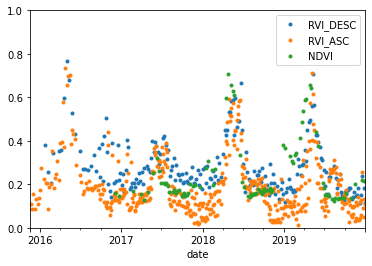

In [10]:
%matplotlib inline
plot = joined_df.plot(marker='.', linestyle='None')
fig = plot.get_figure()
ax = fig.gca()
ax.set_ylim([0, 1])
#fig.savefig("./fig_out/"+crop+"TS.png", bbox_inches='tight')

Time step definition and preprocessing of the data

In [26]:
Tstep      = 15

TIME       = []
DATA       = []
TIME_str   = []
legend_vec = []

time_vec_num = np.asarray([ _.toordinal() for _ in joined_df.index], dtype=np.float32)
TIME.append(time_vec_num)
DATA.append(np.reshape(joined_df['RVI_DESC'].to_numpy(),(joined_df.shape[0],1,1)))

time_vec_num = np.asarray([ _.toordinal() for _ in joined_df.index], dtype=np.float32)
TIME.append(time_vec_num)
DATA.append(np.reshape(joined_df['RVI_ASC'].to_numpy(),(joined_df.shape[0],1,1)))   

time_vec_num = np.asarray([ _.toordinal() for _ in joined_df.index], dtype=np.float32)
TIME.append(time_vec_num)
DATA.append(np.reshape(joined_df['NDVI'].to_numpy(),(joined_df.shape[0],1,1)))

time_vec_MIN        = np.min(list(pd.core.common.flatten(TIME)))
time_vec_MAX        = np.max(list(pd.core.common.flatten(TIME)))
output_timevec      = np.array(range(int(time_vec_MIN),int(time_vec_MAX),Tstep),dtype=float)  
output_time         = [datetime.fromordinal(int(_)) for _ in output_timevec]

nt = 1

In [23]:
%%time
print('MOGPR Being calculated')
master_ind = 1
out_mean, out_std, out_qflag, out_model = MOGRP_GPY_retrieval(DATA[:],TIME[:],master_ind,output_timevec,nt)

MOGPR Being calculated
Wall time: 38.8 s


Postprocessing of MOGPR data

In [27]:
nout = len(out_mean)
out_mean_list = []
for ind in range(nout):
    out_mean_list.append(out_mean[ind].ravel())
    
df_mogpr_out_mean = pd.DataFrame(np.column_stack(out_mean_list), columns=['RVI_DESC', 'RVI_ASC', 'NDVI'])
df_mogpr_out_mean.index = output_time
df_mogpr_out_mean

,RVI_DESC,RVI_ASC,NDVI
2015-11-20,0.218247,0.121216,0.168598
2015-12-05,0.216901,0.119774,0.166943
2015-12-20,0.229934,0.133744,0.182973
2016-01-04,0.285349,0.193148,0.251131
2016-01-19,0.327884,0.238744,0.303447
...,...,...,...
2019-10-30,0.168095,0.067456,0.106915
2019-11-14,0.158639,0.057319,0.095284
2019-11-29,0.167054,0.066339,0.105633
2019-12-14,0.186932,0.087648,0.130083


(0.0, 1.0)

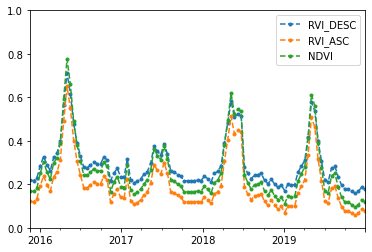

In [28]:
plot =df_mogpr_out_mean.plot(marker='.', linestyle='--')
fig = plot.get_figure()
ax = fig.gca()
ax.set_ylim([0, 1])
#fig.savefig("./fig_out/"+crop+"_MOGPR.png", bbox_inches='tight')

### Uncertainty retrieval per each crop and index. 
First, postprocessing of the data as in the mean.

In [31]:
nout = len(out_mean)
out_std_list = []
for ind in range(nout):
    out_std_list.append(out_std[ind].ravel())
    
df_mogpr_out_std = pd.DataFrame(np.column_stack(out_std_list), columns=['RVI_DESC', 'RVI_ASC', 'NDVI'])
df_mogpr_out_std.index = output_time
df_mogpr_out_std

,RVI_DESC,RVI_ASC,NDVI
2015-11-20,0.042040,0.045066,0.051707
2015-12-05,0.034819,0.037325,0.042826
2015-12-20,0.034590,0.037079,0.042544
2016-01-04,0.034454,0.036934,0.042377
2016-01-19,0.032296,0.034620,0.039723
...,...,...,...
2019-10-30,0.024169,0.025908,0.029727
2019-11-14,0.024270,0.026017,0.029852
2019-11-29,0.024348,0.026100,0.029946
2019-12-14,0.024234,0.025978,0.029807


Show the results

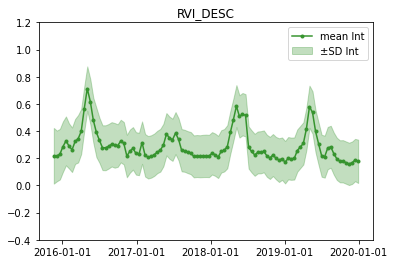

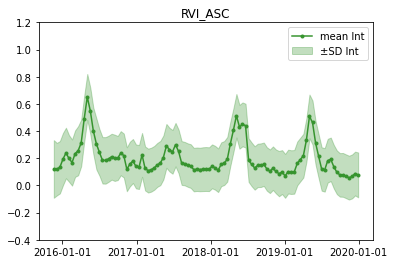

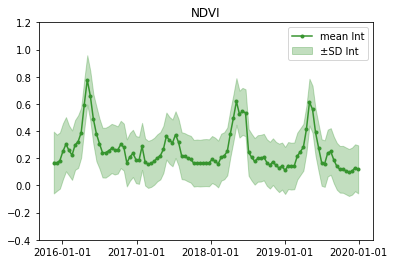

In [35]:
for vi in df_mogpr_out_mean:
    fig, ax = plt.subplots()
    ax.fill_between(df_mogpr_out_mean.index, df_mogpr_out_mean[vi]+np.sqrt(df_mogpr_out_std[vi]), df_mogpr_out_mean[vi]-np.sqrt(df_mogpr_out_std[vi]), label='±SD Int', alpha=0.3, color='#36942E')
    ax.plot(df_mogpr_out_mean.index, df_mogpr_out_mean[vi], '.-', label='mean Int', color='#36942E')
    ax.set_ylim([-0.4, 1.2])
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.set_title(vi)
    plt.legend()
    #fig.savefig("./fig_out/"+crop+"_"+vi+"_MOGPR_std.png", bbox_inches='tight')
    plt.show()
    plt.close()    